In [16]:
import numpy as np
import pandas as pd
import healpy as hp
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
from DS_healpix_fragmentation import one_pixel_fragmentation, matr2dict, radec2pix,\
    draw_proper_circle, pix2radec

In [33]:
pz = pd.read_csv('/home/rt2122/Data/clusters/planck_z.csv')

In [3]:
matrs = {}
for i in range(48):
    matrs[i] = one_pixel_fragmentation(2, i, 10)

In [4]:
dicts = {}
for i in range(48):
    dicts[i] = matr2dict(matrs[i])

In [34]:
pz['border'] = False

In [35]:
pz['pix2'] = radec2pix(pz['RA'], pz['DEC'], 2) 

In [36]:
border = 64
for i in tqdm(range(len(pz))):
    pix = radec2pix(pz['RA'].iloc[i], pz['DEC'].iloc[i], 2048)
    pix2 = pz['pix2'].iloc[i]
    coords = dicts[pix2][pix]
    for x in coords:
        if x < border or x > 1024 - border:
            pz['border'].iloc[i] = True

In [37]:
np.count_nonzero(pz['border'])

260

In [38]:
pz = pz[pz['border'] == False]
pz.index = np.arange(len(pz))
len(pz)

834

In [69]:
def size_pic_class(ra, dec, radius=7.5/60, p_nside=2048):
    from DS_healpix_fragmentation import find_biggest_pixel, one_pixel_fragmentation,\
        draw_proper_circle, matr2dict
    
    o_nside, o_pix = find_biggest_pixel(ra, dec, radius)
    matr = one_pixel_fragmentation(o_nside, o_pix, int(np.log2(p_nside // o_nside)))
    return np.count_nonzero(draw_proper_circle(ra, dec, radius, p_nside, mdict=matr2dict(matr), 
            shape=matr.shape, coords_mode=False))

In [70]:
pz['len'] = 0

In [80]:
for i in tqdm(range(len(pz))):
    pz['len'].iloc[i]=np.count_nonzero(draw_proper_circle(pz['RA'].iloc[i], 
                pz['DEC'].iloc[i], shape=(1024, 1024), 
                  radius=7.5/60, mdict=dicts[pz['pix2'].iloc[i]], nside=2048, 
                                                          coords_mode=False))

/home/rt2122/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [22]:
masks = {}
size = 1024
for i in tqdm(range(48)):
    mask = np.zeros((size, size), dtype=np.bool)
    for idx in range(size):
        for b_idx in [0, size-1]:
            for pair in [(idx, b_idx), (b_idx, idx)]:
                pix = matrs[i][pair]
                ra, dec = pix2radec(pix, nside=2048) 
                mask = np.logical_or(mask, draw_proper_circle(ra, dec, shape=mask.shape,
                    radius=7.5/60, mdict=dicts[i], nside=2048, coords_mode=False))
    masks[i] = mask

In [25]:
all_mask = np.sum([masks[i] for i in range(48)], axis=0)
all_mask.shape

(1024, 1024)

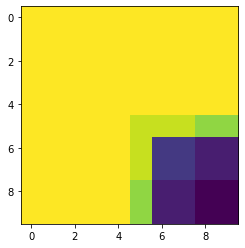

In [27]:
plt.imshow(all_mask[:10, :10])

In [79]:
idx =331 
pz.iloc[idx]

Name           PSZ2 G135.06+54.39
RA                         178.09
DEC                       61.3191
z                          0.3169
M500                      5.40514
MCXC                             
RedMAPPer                        
border                      False
pix2                            7
len                            82
Name: 331, dtype: object

In [75]:
np.count_nonzero(draw_proper_circle(pz['RA'].iloc[idx], pz['DEC'].iloc[idx], shape=(1024, 1024), 
                  radius=7.5/60, mdict=dicts[pz['pix2'].iloc[idx]], nside=2048, coords_mode=False))

82

In [46]:
pz['len'].mean()

79.64868105515588

In [81]:
pz['len'].min(), pz['len'].mean(), pz['len'].max()

(76, 82.17745803357315, 87)

In [82]:
pz[pz['len'] < 40]

,Name,RA,DEC,z,M500,MCXC,RedMAPPer,border,pix2,len
